In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score

seed = np.random.seed(42)
rng = np.random.RandomState(42)

import warnings
warnings.filterwarnings('ignore')

In [17]:
# knn
n_neighbour = np.arange(5, 26, 2) 
metric = ['manhattan', 'euclidean','chebyshev']

# svc
C = np.logspace(-5,5)

# trees
rf_n_estimators = np.arange(50, 151, 25)
rf_max_depth = np.arange(15, 51, 5)
rf_max_features = ['auto', 'log2']

# set 5-fold cross-validation, so we can reuse folds for comparability
cv = KFold(n_splits=5, random_state=rng)

In [18]:
# decide which dataset and scaling
DATASET = 'num'

SCALING = True

In [19]:
# load selected dataset
if DATASET == 'cat':
    df = pd.read_csv("../data/speeddating/speeddating_cat.csv")
else:
    
    df = pd.read_csv("../data/speeddating/speeddating_num.csv")

train, test = train_test_split(df, test_size=0.2, random_state=44)

X_train = train.drop(['match'], axis=1)
y_train = train['match']
X_test = test.drop(['match'], axis=1)
y_test = test['match']

In [20]:
# scaling if enabled
if SCALING:
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

In [21]:
# generate strings for labels and filenames
sscaled = 'min-max-scaled' if SCALING else 'unscaled'
dscaled = '_sc' if SCALING else ''
sdata = 'numeric' if DATASET == 'num' else 'categorical'
ddata = '_num' if DATASET == 'num' else '_cat'

In [22]:
def knn_grid(X_train, y_train):
    print('KNN')
    grid = GridSearchCV(estimator=KNeighborsClassifier(),
                        param_grid={'n_neighbors': n_neighbour,'metric': metric},
                        cv=cv,
                        refit = "balanced_accuracy")
    grid.fit(X_train, y_train)
    print('Best Parameters with a score of is Accuracy of', grid.best_score_)
    print(grid.best_params_)
    return grid

knn = knn_grid(X_train, y_train)
best_knn = knn.best_estimator_

KNN
Best Parameters with a score of is Accuracy of 0.9259453904128708
{'metric': 'euclidean', 'n_neighbors': 23}


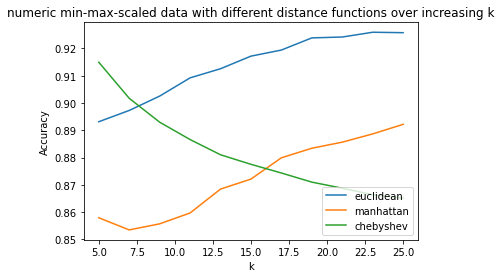

In [26]:
def print_knn():
    y = n_neighbour
    knn_cv = pd.DataFrame(knn.cv_results_)
    euclidean = knn_cv[knn_cv['param_metric'] == 'euclidean']['mean_test_score']
    manhattan = knn_cv[knn_cv['param_metric'] == 'manhattan']['mean_test_score']
    chebyshev = knn_cv[knn_cv['param_metric'] == 'chebyshev']['mean_test_score']
    plt.plot(y, euclidean)
    plt.plot(y, manhattan)
    plt.plot(y, chebyshev)
    plt.legend(['euclidean','manhattan','chebyshev'], loc='lower right')
    plt.title(f'{sdata} {sscaled} data with different distance functions over increasing k')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.savefig(f'sd_knn_metric{ddata}{dscaled}.png')
    plt.show()
    
print_knn()

In [24]:
def svc_grid(X_train, y_train):
    print('SVC')
    grid = GridSearchCV(estimator=LinearSVC(random_state=rng, dual=False),
                        param_grid={'C': C},
                        cv=cv)
    grid.fit(X_train, y_train)
    print('Best Parameters with a score of is Accuracy of', grid.best_score_)
    print(grid.best_params_)
    return grid

svc = svc_grid(X_train, y_train)
best_svc = svc.best_estimator_

SVC
Best Parameters with a score of is Accuracy of 1.0
{'C': 0.004498432668969444}


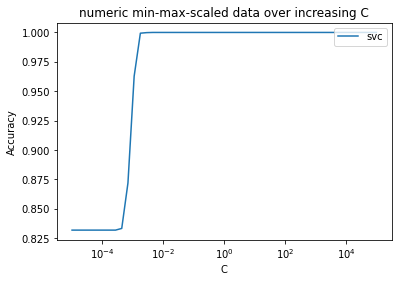

In [27]:
def print_svc():
    svc_cv = pd.DataFrame(svc.cv_results_)
    plt.plot(svc_cv['param_C'], svc_cv['mean_test_score'])
    plt.title(f'{sdata} {sscaled} data over increasing C')
    plt.legend(['svc'], loc='upper right')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.xscale('log')
    plt.savefig(f'sd_svc_metric{ddata}{dscaled}.png')
    plt.show()
    
print_svc()

In [2]:
def get_knn_scores(X_train, y_train, X_test, y_test, k_range, metric):
    P, R, A, BA, ks = [], [], [], [], []
    for k in k_range:
        if k % 2 != 0:
            knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric=metric)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)

            P.append(precision_score(y_test, y_pred))
            R.append(recall_score(y_test, y_pred))
            A.append(accuracy_score(y_test, y_pred))
            BA.append(balanced_accuracy_score(y_test, y_pred))
            ks.append(k)
    
    return P,R,A,BA, ks


def get_svc_scores(X_train, y_train, X_test, y_test, C_range):
    P, R, A, BA, Cs = [], [], [], [], []
    for C in C_range:
        svc = LinearSVC(random_state=42, C=C, dual=False)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)

        P.append(precision_score(y_test, y_pred))
        R.append(recall_score(y_test, y_pred))
        A.append(accuracy_score(y_test, y_pred))
        BA.append(balanced_accuracy_score(y_test, y_pred))
        Cs.append(C)
    
    return P,R,A,BA, Cs

## kNN

In [7]:
 # manhattan | euclidean | chebyshev
metric = 'chebyshev'
k_range = np.arange(1,29)

P,R,A,BA,y = get_knn_scores(X_train, y_train, X_test, y_test, k_range, metric)

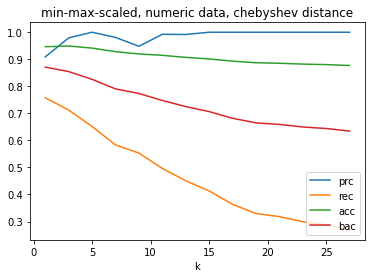

In [8]:
plt.plot(y, P)
plt.plot(y, R)
plt.plot(y, A)
plt.plot(y, BA)
plt.legend(['prc', 'rec', 'acc', 'bac'], loc='lower right')
plt.title(f'{sscaled}, {sdata} data, {metric} distance')
plt.xlabel('k')
# plt.savefig(f'knn{ddata}{dscaled}_{metric}.png')
plt.show()

## SVC

In [9]:
C_range = np.logspace(-4, -2, num=50)

P,R,A,BA,y = get_svc_scores(X_train, y_train, X_test, y_test, C_range)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

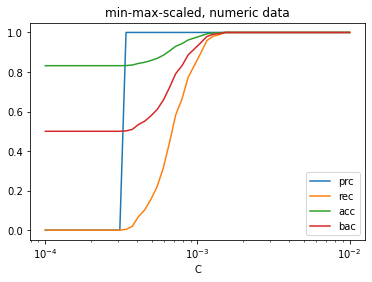

In [10]:
plt.plot(y, P)
plt.plot(y, R)
plt.plot(y, A)
plt.plot(y, BA)
plt.legend(['prc', 'rec', 'acc', 'bac'], loc='lower right')
plt.title(f'{sscaled}, {sdata} data')
plt.xlabel('C')
plt.xscale('log')
# plt.savefig(f'svc{ddata}{dscaled}.png')
plt.show()